# Imports

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

# HF datasets
from datasets import load_dataset_builder, load_dataset, DatasetDict

# rubrix
import rubrix as rb
from rubrix.labeling.text_classification import Rule
from rubrix.labeling.text_classification import WeakLabels
from rubrix.labeling.text_classification import Snorkel

# sklearn
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [30]:
pd.set_option('display.max_colwidth', 400)

# SET SEED
RANDOM_STATE = 42

# Data

## `ag_news` dataset
[ag_news](https://huggingface.co/datasets/ag_news)

In [31]:
dataset_info = load_dataset_builder("ag_news")

2022-09-28 17:33:43.292 | WARNING  | datasets.builder:_create_builder_config:473 - Using custom data configuration default


In [32]:
print(dataset_info.info.description)

AG is a collection of more than 1 million news articles. News articles have been
gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of
activity. ComeToMyHead is an academic news search engine which has been running
since July, 2004. The dataset is provided by the academic comunity for research
purposes in data mining (clustering, classification, etc), information retrieval
(ranking, search, etc), xml, data compression, data streaming, and any other
non-commercial activity. For more information, please refer to the link
http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang
(xiang.zhang@nyu.edu) from the dataset above. It is used as a text
classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann
LeCun. Character-level Convolutional Networks for Text Classification. Advances
in Neural Information Processing Systems 28 (NIPS 2015).



In [33]:
print(dataset_info.info.features["label"])

ClassLabel(num_classes=4, names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)


There are 4 classes:
- World
- Sports
- Business
- Sci/Tech

## Load data

In [34]:
dataset = load_dataset("ag_news")
dataset

2022-09-28 17:33:48.627 | WARNING  | datasets.builder:_create_builder_config:473 - Using custom data configuration default
2022-09-28 17:33:48.640 | WARNING  | datasets.builder:download_and_prepare:732 - Found cached dataset ag_news (/Users/bernardo/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
100%|██████████| 2/2 [00:00<00:00, 46.21it/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

## Splits

We are gonna simulate the following scenario in the real world:

- Let's imagine that we are interested in building a news classifier and have collected the `ag_news` dataset but without labels.
- Our budget for labelling is short, so we decided to label a small subset of data and use weak supervision techniques to label the rest of the data.
- We'll use some of the labeled data to understand the data better and create LFs.
- Also, after training the model on the weakly supervised dataset, we'll evaluate it on labeled data.

__Splits:__
1. We'll use the test set from the HF dataset to test the final classifier.
2. 20% of the labels in the training set will be used for creating LFs and validation.
2. We'll use weak supervision to create a weakly supervised dataset

In [35]:
def generate_splits(
    dataset: DatasetDict,
    unlabeled_frac: float
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:

  train_data = pd.DataFrame(dataset["train"])
  # drop x% of the labels
  unlabeled_train_data = train_data.sample(
      frac=unlabeled_frac,
      random_state=RANDOM_STATE
  ).drop("label", axis=1)
  # indexes
  unlabeled_train_idxs = unlabeled_train_data.index
  # labeled training data
  validation_data = train_data.loc[~train_data.index.isin(unlabeled_train_idxs)]
  assert np.intersect1d(
    unlabeled_train_data.index, validation_data.index
  ).shape[0] == 0, AssertionError(
      "Duplicate data points. Check labeled and unlabeled splits."
  )
  # test set
  test_data = pd.DataFrame(dataset["test"])

  return unlabeled_train_data, validation_data, test_data

In [36]:
# generate splits
unlabeled_data, validation_data, test_data = generate_splits(dataset, 0.8)

In [37]:
unlabeled_data.shape, validation_data.shape, test_data.shape

((96000, 1), (24000, 2), (7600, 2))

# Quick EDA

In [38]:
unlabeled_data.head()

,text
71787,"BBC set for major shake-up, claims newspaper London - The British Broadcasting Corporation, the world #39;s biggest public broadcaster, is to cut almost a quarter of its 28 000-strong workforce, in the biggest shake-up in its 82-year history, The Times newspaper in London said on Monday."
67218,Marsh averts cash crunch Embattled insurance broker #39;s banks agree to waive clause that may have prevented access to credit. NEW YORK (Reuters) - Marsh amp; McLennan Cos.
54066,"Jeter, Yankees Look to Take Control (AP) AP - Derek Jeter turned a season that started with a terrible slump into one of the best in his accomplished 10-year career."
7168,"Flying the Sun to Safety When the Genesis capsule comes back to Earth with its samples of the sun, helicopter pilots will be waiting for it, ready to snag it out of the sky."
29618,"Stocks Seen Flat as Nortel and Oil Weigh NEW YORK (Reuters) - U.S. stocks were set to open near unchanged on Thursday after a warning from technology bellwether Nortel Networks Corp. &lt;A HREF=""http://www.investor.reuters.com/FullQuote.aspx?ticker=NT.N target=/stocks/quickinfo/fullquote""&gt;NT.N&lt;/A&gt; dimmed hopes, while stubbornly high oil prices also weighed on sentiment."


In [39]:
print(f"There are {unlabeled_data.shape[0]} data points.")

There are 96000 data points.


## Length of the inputs

In [40]:
def calculate_input_len(x: str) -> int:
  return len(x.split(" "))

In [41]:
unlabeled_data["len"] = unlabeled_data["text"].map(calculate_input_len)

In [42]:
def plot_length_distribution(df: pd.DataFrame) -> None:
  plt.title("Length distribution")
  sns.histplot(
      df,
      x="len",
      stat="count",
      bins=50
  )
  plt.xticks(df.len)
  plt.xlabel("Length")
  plt.show()

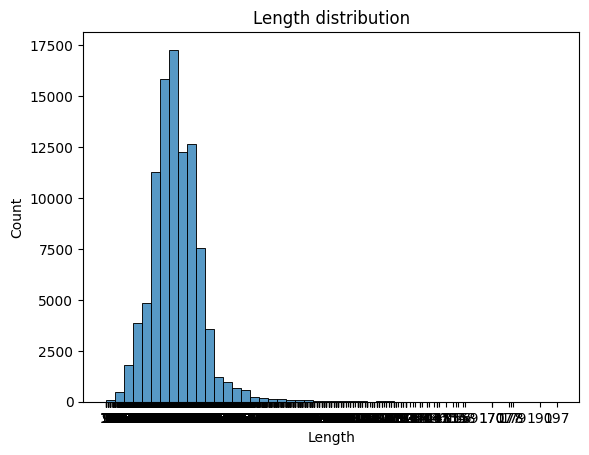

In [43]:
plot_length_distribution(unlabeled_data)

# Log unlabeled data and validation set to Rubrix

We use Rubrix and Snorkel label's model to create the weak labels. The workflow is as follows:

1. Log unlabeled data and labeled validation set to Rubrix
2. Create Labelling Functions (LFs) by leveraging Rubric UI and comparing the performance of these LFs against the validation set. As we don't have a lot of time for understanding the data, the LFs will mainly rely on pattern matching.
3. Denoise the weak labels using Snorkel's label model. This model is already integrated into Rubrix workflow. The Snorkel label model uses a generative model to produce probabilistic labels that can be used to train a downstream model. It's also able to capture correlations between LFs, which can be important.
4. Train a baseline model and test it on the validation set to see if it outperforms Snorkel's model.

In [49]:
labels = dataset_info.info.features["label"].names
labels

['World', 'Sports', 'Business', 'Sci/Tech']

In [50]:
test_data.head()

,text,label
0,Fears for T N pension after talks Unions representing workers at Turner Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.,2
1,"The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.",3
2,"Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.",3
3,"Prediction Unit Helps Forecast Wildfires (AP) AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning will strike in places he expects. Winds will pick up, moist places will dry and flames will roar.",3
4,"Calif. Aims to Limit Farm-Related Smog (AP) AP - Southern California's smog-fighting agency went after emissions of the bovine variety Friday, adopting the nation's first rules to reduce air pollution from dairy cow manure.",3


In [51]:

# build our test records
records = []

for _, row in unlabeled_data.iterrows():
    text = row.text
    record = rb.TextClassificationRecord(
        text=text
    )
    records.append(record)

for _, row in validation_data.iterrows():
    text = row.text
    label_idx = row.label
    record = rb.TextClassificationRecord(
        text=text,
        annotation=labels[label_idx]
    )
    records.extend([record])

# log the records to Rubrix
#rb.log(records, name="ag_news_v1")

100%|██████████| 120000/120000 [04:26<00:00, 450.74it/s]

120000 records logged to http://localhost:6900/datasets/rubrix/ag_news_v1


BulkResponse(dataset='ag_news_v1', processed=120000, failed=0)

# Denoise weak labels

In [7]:
weak_labels = WeakLabels(dataset="ag_news_v1")

Applying rules: 100%|██████████| 120000/120000 [00:02<00:00, 45177.22it/s]


In [44]:
weak_labels.summary()

,label,coverage,annotated_coverage,overlaps,conflicts,correct,incorrect,precision
war,{World},0.015533,0.016000,0.005492,0.002283,291,93,0.757812
war AND country,{World},0.000975,0.001042,0.000975,0.000092,23,2,0.920000
minister*,{World},0.030142,0.029125,0.008683,0.003183,608,91,0.869814
minister* AND countr*,{World},0.002983,0.002625,0.002983,0.000350,56,7,0.888889
conflict,{World},0.003042,0.003417,0.000992,0.000167,70,12,0.853659
countr* AND war,{World},0.001433,0.001417,0.001433,0.000108,32,2,0.941176
politic*,{World},0.012500,0.012708,0.003767,0.001675,227,78,0.744262
*ball,{Sports},0.029600,0.029792,0.019808,0.001667,653,62,0.913287
footbal*,{Sports},0.013042,0.012625,0.012650,0.000550,272,31,0.897690
footbal* AND game,{Sports},0.001708,0.001542,0.001708,0.000108,32,5,0.864865


Coverage = 38.8%

Annotated coverage = 38.8%

No big difference -> low risk of overfitting

In [9]:
# create the label model
label_model = Snorkel(weak_labels, verbose=True, device="cpu")

# default
params = {
    "n_epochs": 100,
    "lr": 0.001,
    "optimizer": "sgd",
    
}

# fit the model
label_model.fit(include_annotated_records=False, **params)

100%|██████████| 100/100 [00:00<00:00, 733.52epoch/s]


In [10]:
print(label_model.score(output_str=True))

              precision    recall  f1-score   support

    Sci/Tech       0.81      0.72      0.76      2838
      Sports       0.80      0.92      0.86      2311
    Business       0.75      0.81      0.78      2677
       World       0.85      0.71      0.77      1496

    accuracy                           0.79      9322
   macro avg       0.80      0.79      0.79      9322
weighted avg       0.80      0.79      0.79      9322



Experimented with different hyperparams and didn't see a significant change in the metrics. Kept the default ones.

# Prepare training set with probabilistic labels

In [11]:
records = label_model.predict()

In [12]:
label2int = {'Sports': 0, 'Sci/Tech': 1, 'World': 2, 'Business': 3}

# extract training data
X_train = [rec.text for rec in records]
y_train = [label2int[rec.prediction[0][0]] for rec in records]

In [28]:
print(f"{len(X_train)} data points in the training set.")

37339 data points in the training set.


In [15]:
# quick look at our training data with the weak labels from our label model
with pd.option_context('display.max_colwidth', None):
    display(pd.DataFrame({"text": X_train, "label": y_train}))

,text,label
0,"Apple v. Apple: Perfect harmony? As eager Macintosh developers waited for Steve Jobs to speak, the familiar strains of quot;Magical Mystery Tour quot; filled the darkened hall at an Apple Computer conference in June.",1
1,"Violence still boosts companies #39; bottom line In the grisly video game Manhunt, players lurk in the shadows and use plastic bags, shards of glass and hammers to murder their enemies.",0
2,"Stocks Cautious Amid High Oil Prices NEW YORK Sept. 29, 2004 - US stocks are seen in a cautious mood at the open as investors take on board a persistently high oil price and reflect on Tuesday #39;s poor consumer confidence reading.",3
3,"Blackburn make move for Wales manager Hughes Blackburn Rovers have approached the Football Association of Wales (FAW) for permission to speak to Wales manager Mark Hughes, Welsh soccer #39;s ruling body said on Wednesday.",0
4,"Fujitsu and Cisco Team Up for IP Networks Fujitsu Limited and Cisco Systems, Inc. today announced that they have reached a fundamental agreement to enter into a strategic alliance focusing on routers and switches that will enable service providers",3
...,...,...
37334,"CA posts Q2 loss on restitution charges OCTOBER 21, 2004 (IDG NEWS SERVICE) - Computer Associates International Inc. yesterday reported a 6 increase in revenue during its second fiscal quarter but posted a \$94 million loss after paying to settle government investigations into the company.",3
37335,Smolinski helps US get in win column A couple of players who weren #39;t able to crack the US lineup when the World Cup began earlier this week helped propel the Americans to victory in a game they had no choice but to win.,0
37336,Microsoft Battle With EU Moved to Court (AP) AP - Microsoft Corp.'s five-year legal battle in Europe moved into a public courtroom for the first time Thursday as the software giant tried to get the European Union's landmark antitrust ruling against it lifted.,1
37337,"Blue Chips Edge Down, Apple Lifts Tech NEW YORK (Reuters) - Blue-chip stocks fell slightly on Monday after No. 1 retailer Wal-Mart Stores Inc. &lt;A HREF=""http://www.investor.reuters.com/FullQuote.aspx?ticker=WMT.N target=/stocks/quickinfo/fullquote""&gt;WMT.N&lt;/A&gt; reported lower-than-expected Thanksgiving sales, while technology shares were lifted by a rally in Apple Computer Inc. &lt;A HREF=""http://www.investor.reuters.com/FullQuote.aspx?ticker=AAPL.O target=/stocks/quickinfo/fullquote""&gt;AAPL.O&lt;/A&gt;.",3


In [16]:
# retrieve records with annotations for the validation set
val_data = weak_labels.records(has_annotation=True)

# extract text and labels
X_val = [rec.text for rec in val_data]
y_val = [label2int[rec.annotation] for rec in val_data]

In [27]:
print(f"{len(X_val)} data points in the validation set.")

24000 data points in the validation set.


# Baseline

We are gonna train a very simple text classifier that will use as our baseline.

In [18]:
model = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

In [19]:
model.fit(
    X=X_train,
    y=y_train,
)

Pipeline(steps=[('vect', CountVectorizer()), ('clf', MultinomialNB())])

In [20]:
predictions = model.predict(X_val)

In [21]:
print(classification_report(y_val, predictions, target_names=list(label2int.keys())))

              precision    recall  f1-score   support

      Sports       0.84      0.99      0.91      5927
    Sci/Tech       0.80      0.83      0.82      5957
       World       0.90      0.84      0.87      6043
    Business       0.86      0.75      0.80      6073

    accuracy                           0.85     24000
   macro avg       0.85      0.85      0.85     24000
weighted avg       0.85      0.85      0.85     24000



85% on the validation set isn't that bad for a very simple model.

# Save training set

In [70]:
#weakly_supervised_training_set = pd.DataFrame({"text": X_train, "label": y_train})

In [71]:
#weakly_supervised_training_set.to_csv("../data/ag_news_training_data.csv", #

In [72]:
#validation_data.to_csv("../data/ag_news_validation_data.csv"#

In [79]:
#test_data.to_csv("../data/ag_news_test_data.csv#", index=False)